In [450]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
#from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
r = pd.read_pickle("sample.pickle")

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

In [140]:
#r = r.fillna(0).astype(int)

train, valid = split_data(r)
train, test = split_data(train)

In [139]:
print("train .{}".format(train.shape),\
     "test .{}".format(test.shape),\
     "valid .{}".format(valid.shape))

train .(23419, 180) test .(13991, 180) valid .(9708, 180)


In [478]:
#NNようのデータ制作　引数に前処理されたデータを入力することでNN用のデータ分割、処理を行う
class NN_data():
    def __init__(self, data, rank=False):
        train, test = split_data(data)
        train, valid = split_data(train)

        if rank == True:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["rank"] # 1or0

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["rank"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["rank"]

            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid
        
        else:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["ranking"] #1to5 or 0

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["ranking"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["ranking"]
            
            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid

        X_train = np.array(X_train) 
        y_train = np.array(y_train) 
        X_test = np.array(X_test) 
        y_test = np.array(y_test) 
        X_valid = np.array(X_valid) 
        y_valid = np.array(y_valid) 

        X_train =X_train.astype(np.float32)
        y_train = y_train.astype(np.int32)[:] 
        X_test =X_test.astype(np.float32)
        y_test = y_test.astype(np.int32)[:] 
        X_valid =X_valid.astype(np.float32)
        y_valid = y_valid.astype(np.int32)[:] 

        sc = StandardScaler()

        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        X_valid = sc.fit_transform(X_valid)

        self.X_train = X_train
        self.X_test = X_test
        self.X_valid = X_valid
        
        self.y_train = y_train
        self.y_test = y_test
        self.y_valid = y_valid
        
    def learning(self):
        #sigmoid or softmax
        input_data = self.X_train
        num = len(np.unique(self.y_train, return_inverse=True)[0]-1) 
        if num == 1:
            model = keras.models.Sequential()

            #全結合層　接続ノード数344, 活性化関数relu, インプット数172
            model.add(keras.layers.Dense(400, activation="relu", input_shape = input_data.shape[1:]))

            #2
            model.add(keras.layers.Dense(120, activation="relu"))

            #3
            model.add(keras.layers.Dense(240, activation="relu"))

            #4
            model.add(keras.layers.Dense(480, activation="relu"))

            #5
            model.add(keras.layers.Dense(240, activation="relu"))

            #6
            model.add(keras.layers.Dense(120, activation="relu"))

            #7
            model.add(keras.layers.Dense(num, activation="sigmoid"))

            self.summary = model.summary()
            self.model = model
        else:
            model = keras.models.Sequential()

            #全結合層　接続ノード数344, 活性化関数relu, インプット数172
            model.add(keras.layers.Dense(400, activation="relu", input_shape = input_data.shape[1:]))
            model.add(Dropout(0.1))

            #2
            model.add(keras.layers.Dense(120, activation="relu"))
            model.add(Dropout(0.1))

            #3
            model.add(keras.layers.Dense(240, activation="relu"))
            model.add(Dropout(0.1))

            #4
            model.add(keras.layers.Dense(480, activation="relu"))
            model.add(Dropout(0.1))

            #5
            model.add(keras.layers.Dense(240, activation="relu"))
            model.add(Dropout(0.1))

            #6
            model.add(keras.layers.Dense(120, activation="relu"))
            model.add(Dropout(0.1))

            #7
            model.add(keras.layers.Dense(num , activation="softmax"))

            self.summary = model.summary()
            self.model = model
        
    def compile(self, loss="binary_crossentropy", lr=1e-4, metrics="accuracy"):
        #if activfunc = sigmoid : binary_crossentropy
        #if activfunc = softmax : sparse_categorical_crossentropy
        # https://keras.io/ja/losses/
        model = self.model
        model.compile(loss=loss, optimizer=keras.optimizers.\
              Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),\
             metrics=[metrics])
        
        self.model = model

    def fit(self, epoch=128, batch=1024):
        early_stopping = EarlyStopping(monitor="val_loss", patience=64, restore_best_weights=True)
        history = self.model.fit(self.X_test, self.y_test, epochs=epoch,\
                        batch_size = batch,\
                        validation_data=(self.X_valid, self.y_valid), verbose=1, callbacks=[early_stopping])
        self.history = history

        


In [491]:
rr = NN_data(r, rank=True)

In [492]:
rr.learning()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 400)               69200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 120)               48120     
_________________________________________________________________
dropout_25 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 240)               29040     
_________________________________________________________________
dropout_26 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 480)             

In [493]:
rr.compile(loss="sparse_categorical_crossentropy", lr=1e-6)

In [494]:
rr.fit()

Epoch 1/128
14/14 [==============================] - 1s 54ms/step - loss: 0.6416 - accuracy: 0.7219 - val_loss: 0.6505 - val_accuracy: 0.7629
Epoch 2/128
14/14 [==============================] - 1s 46ms/step - loss: 0.6351 - accuracy: 0.7411 - val_loss: 0.6469 - val_accuracy: 0.7682
Epoch 3/128
14/14 [==============================] - 1s 41ms/step - loss: 0.6348 - accuracy: 0.7346 - val_loss: 0.6434 - val_accuracy: 0.7709
Epoch 4/128
14/14 [==============================] - 1s 41ms/step - loss: 0.6315 - accuracy: 0.7442 - val_loss: 0.6400 - val_accuracy: 0.7731
Epoch 5/128
14/14 [==============================] - 1s 42ms/step - loss: 0.6284 - accuracy: 0.7477 - val_loss: 0.6367 - val_accuracy: 0.7745
Epoch 6/128
14/14 [==============================] - 1s 41ms/step - loss: 0.6249 - accuracy: 0.7534 - val_loss: 0.6334 - val_accuracy: 0.7752
Epoch 7/128
14/14 [==============================] - 1s 41ms/step - loss: 0.6223 - accuracy: 0.7585 - val_loss: 0.6302 - val_accuracy: 0.7755
Epoch 

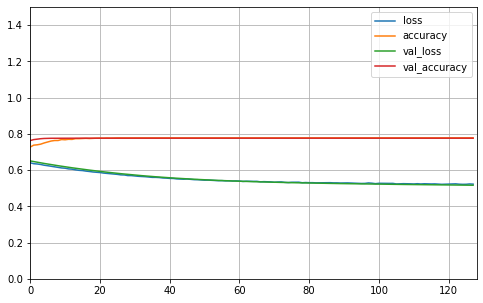

In [498]:
#学習曲線のプロット
pd.DataFrame(rr.history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(-0,1.5)
plt.gca().set_xlim(0,128)
plt.show()

In [499]:
y_pred = np.argmax(model.predict(rr.X_test), axis=-1)
#print(y_pred.shape)
print("正解データ")
print(rr.y_test)
print("予測結果データ")
print(y_pred)
#print(model.predict(X_test))

正解データ
[0 0 1 ... 1 0 0]
予測結果データ
[ 82 393 354 ... 234 147 176]


In [433]:
pd.DataFrame(rr.y_test)[:20]

,0
0,4
1,0
2,3
3,0
4,0
5,1
6,2
7,5
8,3
9,0


In [500]:
pd.DataFrame(y_pred)[:20]

,0
0,82
1,393
2,354
3,317
4,224
5,78
6,337
7,219
8,284
9,284


In [442]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=NN_data(r).X_train.shape[1:])) #1 or 0
model.add(Dropout(0.2))
#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

NameError: name 'Dropout' is not defined

In [243]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.\
              Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False),\
             metrics=["accuracy"])

In [245]:
history = model.fit(NN_data(r).X_test, NN_data(r).y_test, epochs=128,\
                    batch_size = 1024,\
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/128
14/14 [==============================] - 1s 44ms/step - loss: 0.4074 - accuracy: 0.0764 - val_loss: 1.6161 - val_accuracy: 0.2240
Epoch 2/128
14/14 [==============================] - 1s 37ms/step - loss: -0.2419 - accuracy: 0.0745 - val_loss: 3.8771 - val_accuracy: 0.2240
Epoch 3/128
14/14 [==============================] - 1s 37ms/step - loss: -1.1960 - accuracy: 0.0751 - val_loss: 9.5106 - val_accuracy: 0.2240
Epoch 4/128
14/14 [==============================] - 1s 37ms/step - loss: -3.4308 - accuracy: 0.0735 - val_loss: 23.2735 - val_accuracy: 0.2240
Epoch 5/128
14/14 [==============================] - 1s 37ms/step - loss: -11.3197 - accuracy: 0.0751 - val_loss: 59.9610 - val_accuracy: 0.2240
Epoch 6/128
14/14 [==============================] - 1s 37ms/step - loss: -32.6529 - accuracy: 0.0724 - val_loss: 153.1414 - val_accuracy: 0.2240
Epoch 7/128
14/14 [==============================] - 1s 37ms/step - loss: -88.4528 - accuracy: 0.0735 - val_loss: 379.4829 - val_accuracy

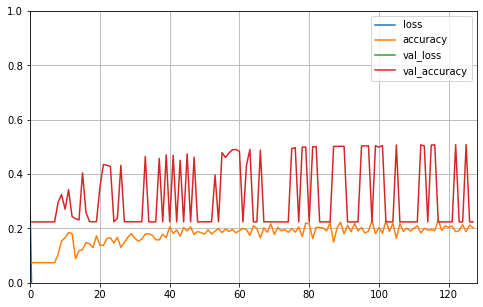

In [246]:
#学習曲線のプロット
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0,128)
plt.show()

In [282]:
model.evaluate(NN_data(r).X_valid, NN_data(r).y_valid, verbose=1)

304/304 [==============================] - 1s 1ms/step - loss: -393362145280.0000 - accuracy: 0.0748


[-393362145280.0, 0.07478368282318115]

In [207]:
y_pred = np.argmax(model.predict(NN_data(r).X_train), axis=1)

#print(y_pred.shape)
print("正解データ")
print(y_test)
print("予測結果データ")
print(y_pred)
#print(model.predict(X_test))

正解データ
[1 0 0 ... 0 0 0]
予測結果データ
[0 0 0 ... 0 0 0]


In [239]:
pd.DataFrame(y_test).value_counts()

0    7533
1    2175
dtype: int64

In [238]:
pd.DataFrame(y_pred).value_counts()

0    13991
dtype: int64

In [302]:
#dataset
X = r#.drop(["rank","ranking","単勝","second","着順","rls"],axis=1)
y = r["ranking"]

train1, test = split_data(X)
train2, valid = split_data(train1)

X_train1 = train1.drop(["rank","ranking","単勝","second","着順","rls","data","date"],axis=1)
X_train1 = X_train1.fillna(0).astype(int)
y_train1 = train1["ranking"]

X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"],axis=1)
X_ttest = X_test.fillna(0).astype(int)
y_test = test["ranking"]

X_train2 = train2.drop(["rank","ranking","単勝","second","着順","rls","date","data"],axis=1)
X_train2 = X_train2.fillna(0).astype(int)
y_train2 = train2["ranking"]

X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","date","data"],axis=1)
X_valid = X_valid.fillna(0).astype(int)
y_valid = valid["ranking"]

In [98]:
a = X_train2.fillna(0).astype(int)
b = X_valid.fillna(0).astype(int)

In [76]:
for i in range(len(a.columns)):
    print(a.columns[i], (a.isnull().any()[i] == True))

枠番 False
馬番 False
斤量 False
course_len False
horse_id False
jockey_id False
年齢 False
体重 False
体重変化 False
n_horses False
着順_5R False
賞金_5R False
着差_5R False
first_corner_5R False
first_to_rank_5R False
first_to_final_5R False
final_to_rank_5R False
着順_course_len_5R False
賞金_course_len_5R False
着差_course_len_5R False
first_corner_course_len_5R False
first_to_rank_course_len_5R False
first_to_final_course_len_5R False
final_to_rank_course_len_5R False
着順_race_type_5R False
賞金_race_type_5R False
着差_race_type_5R False
first_corner_race_type_5R False
first_to_rank_race_type_5R False
first_to_final_race_type_5R False
final_to_rank_race_type_5R False
着順_開催_5R False
賞金_開催_5R False
着差_開催_5R False
first_corner_開催_5R False
first_to_rank_開催_5R False
first_to_final_開催_5R False
final_to_rank_開催_5R False
着順_9R False
賞金_9R False
着差_9R False
first_corner_9R False
first_to_rank_9R False
first_to_final_9R False
final_to_rank_9R False
着順_course_len_9R False
賞金_course_len_9R False
着差_course_len_9R False
firs

In [104]:
for i in range(len(b.columns)):
    print(b.columns[i], (b.isnull().any()[i] == True))

枠番 False
馬番 False
斤量 False
course_len False
horse_id False
jockey_id False
年齢 False
体重 False
体重変化 False
n_horses False
着順_5R False
賞金_5R False
着差_5R False
first_corner_5R False
first_to_rank_5R False
first_to_final_5R False
final_to_rank_5R False
着順_course_len_5R False
賞金_course_len_5R False
着差_course_len_5R False
first_corner_course_len_5R False
first_to_rank_course_len_5R False
first_to_final_course_len_5R False
final_to_rank_course_len_5R False
着順_race_type_5R False
賞金_race_type_5R False
着差_race_type_5R False
first_corner_race_type_5R False
first_to_rank_race_type_5R False
first_to_final_race_type_5R False
final_to_rank_race_type_5R False
着順_開催_5R False
賞金_開催_5R False
着差_開催_5R False
first_corner_開催_5R False
first_to_rank_開催_5R False
first_to_final_開催_5R False
final_to_rank_開催_5R False
着順_9R False
賞金_9R False
着差_9R False
first_corner_9R False
first_to_rank_9R False
first_to_final_9R False
final_to_rank_9R False
着順_course_len_9R False
賞金_course_len_9R False
着差_course_len_9R False
firs

In [303]:
X_nn = np.array(X_train2) 
y_nn = np.array(y_train2) #1 or 0

X_n = np.array(X_train1)
y_n = np.array(y_train1) #1to5 or 0

X_v = np.array(X_valid)
y_v = np.array(y_valid) #1 or 0

ax = np.array(a) # 学習データ
bx = np.array(b) # 検証データ

#数値データに変換
X_nn =X_nn.astype(np.float32)
y_nn = y_nn.astype(np.int32)[:] #1 or 0

X_n = X_n.astype(np.float32)
y_n = y_n.astype(np.int32)[:] #1to5 or 0

X_v = X_v.astype(np.float32)
y_v = y_v.astype(np.int32)[:] #1 or 0

#スケーリング
sc = StandardScaler()
X_nn = sc.fit_transform(X_nn) #1 or 0
X_v= sc.fit_transform(X_v) #1 or 0
X_n = sc.fit_transform(X_n) #1to5 or 0

ax = sc.fit_transform(ax) 
bx = sc.fit_transform(bx)

#print("shape of x : {}". format(X_nn.shape))
#print("shape of y : {}".format(y_nn.shape))

#print("ave:")
#print("Standard deviation:")
#print(X_nn.std(axis=0))

In [307]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=X_nn.shape[1:])) #1 or 0

#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(5, activation="softmax"))

In [81]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=ax.shape[1:])) #1 or 0

#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [308]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 400)               69200     
_________________________________________________________________
dense_80 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_81 (Dense)             (None, 240)               29040     
_________________________________________________________________
dense_82 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_83 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_84 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_85 (Dense)             (None, 5)               

In [309]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.\
              Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False),\
             metrics=["accuracy"])



In [310]:
history = model.fit(a, y_nn, epochs=32,\
                    batch_size = 1024,\
                    validation_data=(bx, y_v), verbose=1)

Epoch 1/32


2022-07-06 18:36:39.624714: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at sparse_xent_op.cc:90 : Invalid argument: Received a label value of 5 which is outside the valid range of [0, 5).  Label values: 5 5 0 0 0 0 0 0 0 0 4 0 0 0 2 0 2 0 0 0 0 5 4 5 0 0 0 0 0 0 0 5 0 0 0 1 0 0 2 4 5 0 4 3 4 0 1 5 0 3 0 0 2 5 0 5 5 0 4 0 0 0 0 3 0 1 1 0 0 0 5 0 1 3 0 0 0 0 0 0 3 0 0 0 4 0 0 4 0 4 4 1 0 0 3 0 0 3 0 0 0 2 3 5 1 0 0 0 0 0 0 0 1 0 0 0 0 3 4 5 0 0 0 4 0 0 0 0 0 0 3 0 0 0 5 0 0 5 0 4 0 0 0 1 0 5 4 3 5 0 4 3 0 0 0 3 0 3 0 1 5 0 1 0 0 0 0 3 2 0 0 0 0 0 0 5 2 3 0 0 0 0 4 1 3 0 2 0 0 0 0 4 0 0 3 0 0 0 0 5 3 0 0 4 0 4 0 0 4 0 0 2 0 1 2 0 0 0 1 0 0 0 0 0 0 5 0 0 0 3 0 0 0 5 1 0 0 4 5 0 0 5 1 0 4 0 0 0 0 0 0 3 0 0 0 5 0 4 0 0 0 0 0 1 0 0 0 5 0 0 0 0 0 0 3 0 2 0 3 3 0 5 0 3 0 0 0 0 0 5 0 2 0 0 4 4 2 4 0 0 0 0 5 0 0 0 3 4 0 0 2 0 0 0 0 1 0 0 0 0 0 5 2 3 0 5 5 0 1 1 0 0 0 0 5 0 1 0 0 0 5 2 0 3 0 0 0 0 0 0 0 0 0 0 1 1 0 0 5 0 5 0 2 0 1 0 0 4 0 2 2 2 0 4 4 0 1 3 0 0 0 0 0 4 0 2 4 0

InvalidArgumentError:  Received a label value of 5 which is outside the valid range of [0, 5).  Label values: 5 5 0 0 0 0 0 0 0 0 4 0 0 0 2 0 2 0 0 0 0 5 4 5 0 0 0 0 0 0 0 5 0 0 0 1 0 0 2 4 5 0 4 3 4 0 1 5 0 3 0 0 2 5 0 5 5 0 4 0 0 0 0 3 0 1 1 0 0 0 5 0 1 3 0 0 0 0 0 0 3 0 0 0 4 0 0 4 0 4 4 1 0 0 3 0 0 3 0 0 0 2 3 5 1 0 0 0 0 0 0 0 1 0 0 0 0 3 4 5 0 0 0 4 0 0 0 0 0 0 3 0 0 0 5 0 0 5 0 4 0 0 0 1 0 5 4 3 5 0 4 3 0 0 0 3 0 3 0 1 5 0 1 0 0 0 0 3 2 0 0 0 0 0 0 5 2 3 0 0 0 0 4 1 3 0 2 0 0 0 0 4 0 0 3 0 0 0 0 5 3 0 0 4 0 4 0 0 4 0 0 2 0 1 2 0 0 0 1 0 0 0 0 0 0 5 0 0 0 3 0 0 0 5 1 0 0 4 5 0 0 5 1 0 4 0 0 0 0 0 0 3 0 0 0 5 0 4 0 0 0 0 0 1 0 0 0 5 0 0 0 0 0 0 3 0 2 0 3 3 0 5 0 3 0 0 0 0 0 5 0 2 0 0 4 4 2 4 0 0 0 0 5 0 0 0 3 4 0 0 2 0 0 0 0 1 0 0 0 0 0 5 2 3 0 5 5 0 1 1 0 0 0 0 5 0 1 0 0 0 5 2 0 3 0 0 0 0 0 0 0 0 0 0 1 1 0 0 5 0 5 0 2 0 1 0 0 4 0 2 2 2 0 4 4 0 1 3 0 0 0 0 0 4 0 2 4 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 4 0 0 0 4 0 0 0 5 0 4 0 2 0 0 2 0 0 4 0 0 5 1 0 1 0 0 5 0 0 0 0 0 0 1 5 0 0 0 3 0 0 0 0 5 1 2 2 0 0 0 0 0 4 0 2 4 0 2 5 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 5 0 0 0 0 0 0 4 0 0 0 5 0 0 0 5 1 0 0 1 5 0 4 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 4 0 3 5 0 0 2 2 0 0 4 0 4 0 0 5 2 2 0 0 5 3 0 0 0 0 0 0 0 2 0 4 0 0 0 0 0 0 2 0 1 3 0 0 4 0 0 0 0 0 0 0 0 1 0 0 3 0 4 0 0 0 3 0 3 0 0 0 5 0 0 0 0 0 0 0 0 0 3 0 0 5 2 0 3 4 0 0 5 1 2 0 0 0 0 0 0 0 2 4 0 5 5 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 0 3 0 4 0 1 0 0 3 5 0 0 0 2 4 0 1 2 3 0 0 4 0 0 0 0 0 3 4 0 0 1 0 0 0 0 2 0 0 0 2 4 5 0 0 0 5 4 5 1 4 0 0 2 5 0 0 1 3 0 2 2 0 4 1 1 0 0 4 3 0 0 0 4 3 0 0 2 0 0 4 0 0 2 0 0 1 0 0 2 0 0 2 4 0 5 0 0 0 0 2 0 0 2 4 0 0 2 0 0 0 0 4 2 0 1 5 0 0 0 5 4 0 3 5 1 1 0 0 4 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 2 1 0 0 0 4 0 3 4 0 1 1 0 0 0 4 3 2 2 0 0 0 0 0 1 0 5 2 3 0 1 0 4 0 0 2 0 0 3 0 0 0 0 0 0 3 2 3 5 0 0 0 0 0 0 4 0 0 0 3 0 0 5 0 3 0 5 1 4 0 3 0 5 4 0 0 0 3 0 0 5 4 0 2 0 0 0 3 0 5 0 0 0 0 0 0 5 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 4 0 4 0 4 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 4 0 0 0 3 3 5 0 0 0 2 0 0 5 4 5 5 0 0 5 1 1 2 3 0 0 0 0 0 0 3 0 0 0 0 0 3 2 0 0 2 0 0 0 0 4 5 0 0 0 1 3 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 5 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at var/folders/tm/fn98hw1541vg9yshhxdqfgc80000gn/T/ipykernel_76824/2003203418.py:1) ]] [Op:__inference_train_function_109599]

Function call stack:
train_function


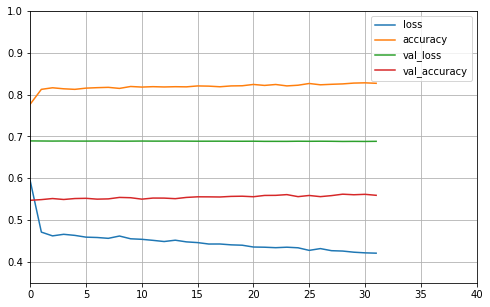

In [127]:
#学習曲線のプロット
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0.35,1)
plt.gca().set_xlim(0,40)
plt.show()

In [119]:
model.evaluate(X_nn, y_nn, verbose=1)

732/732 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.7201


[nan, 0.7201417684555054]

In [ ]:
model.predict()

In [ ]:
ばちい　増やす　さげる
えぽっく　増やす
欠損値　埋める
中関そう　ふやす
dropaut 追加
aleaystopping 追加
race_id level=0 を削除　もしくわ　カテゴリ変数に直す
logloss 使ってみる

In [ ]:
反省点　
日分類で予測を行なった際はラベルの偏りがあったため出力が0に偏った

やること
・1to5 or 0が目的変数の学習を行う
・ラベルの偏りをなくしたデータで学習を行う
